# Vision Investment Rental Worthiness Predictor.

In [72]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

In [73]:
train1 = pd.read_excel("datasets/dataset1.xlsx")
train2 = pd.read_excel("datasets/dataset2.xlsx")

In [74]:
train1.columns

Index(['Row Number', 'Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [75]:
train2.columns

Index(['Row Number', 'Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [76]:
train2 = train2.drop(['Row Number'],axis=1)
train1 = train1.drop(['Row Number'],axis=1)

In [77]:
train = pd.concat([train1,train2]).reset_index()
train.head()

,index,Fico Score,Length of Employment (Months),Length of Current Residency (Months),Monthly Income,Debt to Income percentage,Outcome
0,0,593,56,7,7920,50.313829,1
1,1,744,34,11,8748,24.693483,1
2,2,845,57,29,5582,79.617316,0
3,3,624,23,21,2418,81.520067,0
4,4,832,35,5,6637,85.491807,0


In [78]:
# percentage of 0s and 1s
(train.Outcome.value_counts()/750)*100

1    59.2
0    40.8
Name: Outcome, dtype: float64

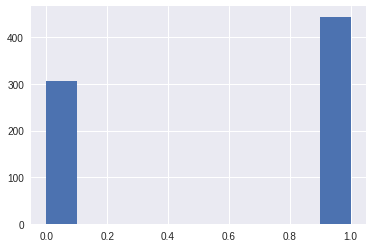

In [79]:
train.Outcome.loc[:,].hist()

In [80]:
train.isnull().sum()

index                                    0
Fico Score                               0
Length of Employment (Months)            0
Length of Current Residency  (Months)    0
Monthly Income                           0
Debt to Income percentage                0
Outcome                                  0
dtype: int64

In [81]:
# prepare values to be considered by the model.
# X includes all the features Fico Score	Length of Employment (Months)	Length of Current Residency (Months)	Monthly Income	Debt to Income percentage	
X = train.iloc[:,1:-1].values

In [82]:
X

array([[  5.93000000e+02,   5.60000000e+01,   7.00000000e+00,
          7.92000000e+03,   5.03138288e+01],
       [  7.44000000e+02,   3.40000000e+01,   1.10000000e+01,
          8.74800000e+03,   2.46934827e+01],
       [  8.45000000e+02,   5.70000000e+01,   2.90000000e+01,
          5.58200000e+03,   7.96173161e+01],
       ..., 
       [  7.55000000e+02,   4.80000000e+01,   9.00000000e+00,
          4.07600000e+03,   2.32497474e+01],
       [  4.26000000e+02,   5.70000000e+01,   8.00000000e+00,
          4.66300000e+03,   6.43538894e+00],
       [  6.62000000e+02,   1.90000000e+01,   5.00000000e+00,
          9.88400000e+03,   7.62563945e+01]])

In [83]:
# Response labels
y = train.iloc[:,6:].values

In [84]:
y

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
X_test

array([[  2.93137673e+01,   7.05000000e+02,   8.00000000e+00,
          2.00000000e+01,   9.54700000e+03,   1.00000000e+00],
       [  4.69451188e+01,   6.76000000e+02,   1.60000000e+01,
          7.00000000e+00,   2.59600000e+03,   0.00000000e+00],
       [  1.93670388e+01,   4.61000000e+02,   2.30000000e+01,
          3.80000000e+01,   3.20600000e+03,   1.00000000e+00],
       ..., 
       [  1.64034679e+01,   7.49000000e+02,   3.00000000e+00,
          2.10000000e+01,   5.42800000e+03,   1.00000000e+00],
       [  4.76567781e+01,   4.42000000e+02,   3.40000000e+01,
          5.10000000e+01,   3.20900000e+03,   0.00000000e+00],
       [  6.40659678e+01,   3.61000000e+02,   8.00000000e+00,
          3.00000000e+01,   9.82100000e+03,   0.00000000e+00]])

In [35]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [36]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_estimators=5,learning_rate=0.02)

In [39]:
y_train[0]

array([   0.,  245.])

In [37]:
model_xgb.fit(X_train,y_train.ravel())

ValueError: y contains new labels: [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan]

In [ ]:
predictions = model_xgb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(X_train,y_train.ravel())

In [ ]:
predictions_rf = model_rf.predict(X_test)

In [ ]:
accuracy_score(y_test,predictions_rf)

In [30]:
train.isnull().sum()

index                                      0
Debt to Income percentage                  0
Fico Score                                 0
Length of Current Residency  (Months)      0
Length of Employment (Months)              0
Monthly Income                             0
Outcome                                    0
Row Number                               250
dtype: int64